In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet50
from torch.utils.data import DataLoader
from tqdm import tqdm


# ---------- Data Augmentation (Two views) ----------
class TwoCropsTransform:
    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        return [self.base_transform(x), self.base_transform(x)]

simsiam_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010)),
])

train_dataset = datasets.CIFAR10(
    root='./data', train=True, download=True,
    transform=TwoCropsTransform(simsiam_transform)
)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0, drop_last=True)

# ---------- MLPs ----------
class MLPHead(nn.Module):
    def __init__(self, in_dim=2048, hidden_dim=2048, out_dim=2048):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_dim, hidden_dim, bias=False),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),

            nn.Linear(hidden_dim, hidden_dim, bias=False),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),

            nn.Linear(hidden_dim, out_dim, bias=False),
            nn.BatchNorm1d(out_dim, affine=False)  # No affine in last BN
        )

    def forward(self, x):
        return self.layers(x)

class Predictor(nn.Module):
    def __init__(self, in_dim=2048, hidden_dim=512, out_dim=2048):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_dim, hidden_dim, bias=False),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.layers(x)

# ---------- SimSiam ----------
class SimSiam(nn.Module):
    def __init__(self, use_predictor=True):
        super().__init__()
        self.encoder = resnet50(weights=None)
        self.encoder.fc = nn.Identity()  # Remove classification layer

        self.projector = MLPHead(in_dim=2048)
        self.use_predictor = use_predictor
        if self.use_predictor:
            self.predictor = Predictor()

    def forward(self, x1, x2, stop_grad=True):
        z1 = self.projector(self.encoder(x1))
        z2 = self.projector(self.encoder(x2))

        if self.use_predictor:
            p1 = self.predictor(z1)
            p2 = self.predictor(z2)
        else:
            p1, p2 = z1, z2

        if stop_grad:
            z1 = z1.detach()
            z2 = z2.detach()

        return p1, p2, z1, z2

# ---------- Loss Function ----------
def negative_cosine_similarity(p, z):
    p = F.normalize(p, dim=1)
    z = F.normalize(z, dim=1)
    return - (p * z).sum(dim=1).mean()

# ---------- Training Function ----------
def train_simsiam(model, train_loader, epochs=100, lr=3e-4, stop_grad=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for (x1, x2), _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            x1, x2 = x1.to(device), x2.to(device)

            p1, p2, z1, z2 = model(x1, x2, stop_grad=stop_grad)
            loss = 0.5 * negative_cosine_similarity(p1, z2) + 0.5 * negative_cosine_similarity(p2, z1)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        scheduler.step()
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1:03d} | Avg Loss: {avg_loss:.4f}")

simsiam_model = SimSiam()  # ← instantiate your model
train_simsiam(simsiam_model, train_loader, epochs=15)  # ← call the function


Epoch 001 | Avg Loss: -0.8575


Epoch 002 | Avg Loss: -0.9785


Epoch 003 | Avg Loss: -0.9399


Epoch 004 | Avg Loss: -0.9556


Epoch 005 | Avg Loss: -0.8531


Epoch 006 | Avg Loss: -0.9606


Epoch 007 | Avg Loss: -0.9823


Epoch 008 | Avg Loss: -0.9867


Epoch 009 | Avg Loss: -0.9880


Epoch 010 | Avg Loss: -0.9867


Epoch 011 | Avg Loss: -0.9854


Epoch 012 | Avg Loss: -0.9820


Epoch 013 | Avg Loss: -0.9715


Epoch 014 | Avg Loss: -0.9109


Epoch 015 | Avg Loss: -0.8986


In [112]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet50
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import copy

# CIFAR-10 test loader
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=0)

# Linear Classifier
class LinearClassifier(nn.Module):
    def __init__(self, feature_dim=2048, num_classes=10):
        super().__init__()
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

# Linear Evaluation
from tqdm import tqdm

def linear_eval(model, train_loader, test_loader, epochs=3, lr=0.1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Freeze encoder
    model.eval()
    for param in model.parameters():
        param.requires_grad = False


    # Linear classifier
    classifier = nn.Linear(2048, 10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(classifier.parameters(), lr=lr, momentum=0.9)

    for epoch in range(epochs):
        classifier.train()
        total_loss = 0
        correct = 0
        total = 0
        loop = tqdm(train_loader, desc=f"[Linear Eval] Epoch {epoch+1}/{epochs}", leave=False)
        for x, target in loop:
            x, target = x.to(device), target.to(device)
            with torch.no_grad():
                feat = model(x)
            output = classifier(feat)
            loss = criterion(output, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()
            total += target.size(0)

            loop.set_postfix(loss=loss.item(), acc=100.*correct/total)

    # Final accuracy on test set
    classifier.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, target in tqdm(test_loader, desc="[Linear Eval] Testing", leave=False):
            x, target = x.to(device), target.to(device)
            feat = model(x)
            output = classifier(feat)
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()
            total += target.size(0)

    return 100. * correct / total

# k-NN Evaluation
def knn_eval(model, train_loader, test_loader, k=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # Extract all features
    train_feats = []
    train_labels = []
    for x, y in tqdm(train_loader, desc="[kNN] Extracting train feats", leave=False):
        x = x.to(device)
        with torch.no_grad():
            feat = model(x)
        train_feats.append(feat.cpu())
        train_labels.append(y)

    train_feats = torch.cat(train_feats)
    train_labels = torch.cat(train_labels)

    correct = 0
    total = 0
    for x, y in tqdm(test_loader, desc="[kNN] Evaluating", leave=False):
        x = x.to(device)
        with torch.no_grad():
            feat = model(x)

        feat = feat.cpu()
        sim = torch.mm(feat, train_feats.T)
        _, topk_indices = sim.topk(k=k, dim=1)
        topk_labels = train_labels[topk_indices]

        preds = []
        for labels in topk_labels:
            pred = torch.bincount(labels).argmax().item()
            preds.append(pred)

        preds = torch.tensor(preds)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return 100. * correct / total


In [57]:
# 4A.Remove stop-gradient
def train_ablation_no_stopgrad(model, train_loader, epochs=100, lr=3e-4):
    print("Running ablation: removing stop-gradient...")
    return train_simsiam(model, train_loader, epochs=epochs, lr=lr, stop_grad=False)

# 4B.Remove predictor
class SimSiamNoPredictor(nn.Module):
    def __init__(self)
        super().__init__()
        self.encoder = resnet50(pretrained=False)
        self.encoder.fc = nn.Identity()
        self.projector = MLPHead(in_dim=2048) 
        # No predictor MLP

    def forward(self, x1, x2, stop_grad=True):
        z1 = self.projector(self.encoder(x1))
        z2 = self.projector(self.encoder(x2))
        p1, p2 = z1, z2  
        if stop_grad:
            z1 = z1.detach()
            z2 = z2.detach()
        return p1, p2, z1, z2


In [59]:
from torchvision.transforms import RandAugment

def get_advanced_augmentations(use_mixup=False, use_cutmix=False, use_randaugment=False):
    aug_list = [
        transforms.RandomResizedCrop(32, scale=(0.2, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
        transforms.RandomGrayscale(p=0.2)
    ]

    if use_randaugment:
        aug_list.insert(0, RandAugment(num_ops=2, magnitude=9))

    aug_list += [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]

    transform = transforms.Compose(aug_list)
    return TwoCropsTransform(transform)


In [17]:
import torch
import torch.nn as nn
import torchvision.models as models
import urllib.request
import os


def download_dino_resnet50():
    url = "https://dl.fbaipublicfiles.com/dino/dino_resnet50_pretrain.pth"
    checkpoint_path = "./dino_resnet50_pretrain.pth"
    if not os.path.exists(checkpoint_path):
        print("Downloading DINO ResNet-50 checkpoint...")
        urllib.request.urlretrieve(url, checkpoint_path)
        print("Download complete.")
    else:
        print("Checkpoint already exists.")
    return checkpoint_path


def load_dino_resnet50_model():
    checkpoint_path = download_dino_resnet50()
    state_dict = torch.load(checkpoint_path, map_location="cpu")

    # Initialize 
    model = models.resnet50(pretrained=False)
    model.fc = nn.Identity()  

    # Extract backbone 
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith("backbone.") and not k.startswith("backbone.fc"):
            new_k = k.replace("backbone.", "")
            new_state_dict[new_k] = v

    missing, unexpected = model.load_state_dict(new_state_dict, strict=False)
    print("Loaded DINO ResNet-50. Missing:", missing, "| Unexpected:", unexpected)

    return model


In [81]:
# SwAV:
import os
import urllib.request
import torch
import torch.nn as nn
from torchvision import models

def download_swav_resnet50():
    url = "https://dl.fbaipublicfiles.com/deepcluster/swav_800ep_pretrain.pth.tar"
    checkpoint_path = "./swav_resnet50_pretrain.pth.tar"
    if not os.path.exists(checkpoint_path):
        print("Downloading SwAV ResNet-50 checkpoint...")
        urllib.request.urlretrieve(url, checkpoint_path)
        print("Download complete.")
    else:
        print("Checkpoint already exists.")
    return checkpoint_path

def load_swav_resnet50_model():
    checkpoint_path = download_swav_resnet50()
    checkpoint = torch.load(checkpoint_path, map_location="cpu")

   
    state_dict = checkpoint.get("state_dict", checkpoint)

    model = models.resnet50(weights=None)
    model.fc = nn.Identity()

    # Rename keys 
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith("module.backbone.") and not k.startswith("module.backbone.fc"):
            new_k = k.replace("module.backbone.", "")
            new_state_dict[new_k] = v

    
    missing, unexpected = model.load_state_dict(new_state_dict, strict=False)

    print("Loaded SwAV ResNet-50.")
    if missing:
        print(" Missing keys:", missing[:5], "..." if len(missing) > 5 else "")
    if unexpected:
        print(" Unexpected keys:", unexpected)

    return model

# SimCLR 
def load_simclr_resnet50_model():
    print("Loading SimCLR-like ResNet-50 (placeholder from torchvision)...")
    model = models.resnet50(pretrained=True)  # ImageNet pretrained
    model.fc = nn.Identity()
    return model

# BYOL 
def load_byol_resnet50_model():
    print("Loading BYOL-like ResNet-50 (placeholder from torchvision)...")
    model = models.resnet50(pretrained=True)
    model.fc = nn.Identity()
    return model


In [65]:
import torch
import torchvision.models as models
import torch.nn as nn

# Load the checkpoin
checkpoint = torch.load('/Users/siddharthtanwar/Documents/York/DL/sim siam/checkpoint_100.tar', map_location='cpu')

simclr_model = models.resnet50(weights=None)
simclr_model.fc = nn.Identity()  


new_state_dict = {}
for k, v in checkpoint.items():
    if k.startswith("encoder."):
        new_k = k[len("encoder."):] 
        new_state_dict[new_k] = v
# Load weights
missing, unexpected = simclr_model.load_state_dict(new_state_dict, strict=False)
print("Loaded SimCLR ResNet-50. Missing:", missing, "| Unexpected:", unexpected)

Loaded SimCLR ResNet-50. Missing: [] | Unexpected: []


In [67]:

checkpoint = torch.load('/Users/siddharthtanwar/Documents/York/DL/sim siam/resnet50_byol_imagenet2012.pth.tar', map_location='cpu', weights_only=False)

# Extract encoder weights
byol_state_dict = checkpoint['online_backbone']


fixed_state_dict = {}
for k, v in byol_state_dict.items():
    if k.startswith("module."):
        fixed_state_dict[k.replace("module.", "")] = v
    else:
        fixed_state_dict[k] = v

# Load into ResNet-50
byol_model = models.resnet50(pretrained=False)
byol_model.fc = nn.Identity()

missing, unexpected = byol_model.load_state_dict(fixed_state_dict, strict=False)
print("Loaded BYOL ResNet-50. Missing:", missing)
print("Unexpected:", unexpected)


Loaded BYOL ResNet-50. Missing: []
Unexpected: []


In [156]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from tqdm import tqdm


class PretrainedWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.encoder = getattr(model, 'encoder', model)
        if hasattr(self.encoder, 'fc'):
            self.encoder.fc = nn.Identity()

    def forward(self, x):
        with torch.no_grad():
            return self.encoder(x)


_cached_loaders = {}

def get_eval_loaders(use_imagenet_stats=True, subset_fraction=1.0, batch_size=128, seed=42):
    from torch.utils.data import Subset
    import random

    if use_imagenet_stats:
        transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),
                                 (0.229, 0.224, 0.225)),
        ])
    else:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    if subset_fraction < 1.0:
        random.seed(seed)
        subset_size = int(len(train_dataset) * subset_fraction)
        subset_indices = random.sample(range(len(train_dataset)), subset_size)
        train_dataset = Subset(train_dataset, subset_indices)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader


# evaluation function 
def evaluate_all_models(model_dict, subset_fraction=1.0, epochs=5):
    results = {}

    for name, model in model_dict.items():
        print(f"\n====== Evaluating {name} ======")

       
        use_imagenet_stats = not ("SimSiam" in name)

      
        train_loader_eval, test_loader_eval = get_eval_loaders(use_imagenet_stats, subset_fraction)

        
        wrapped = PretrainedWrapper(model)

       
        lin_acc = linear_eval(wrapped, train_loader_eval, test_loader_eval, epochs=epochs)
        knn_acc = knn_eval(wrapped, train_loader_eval, test_loader_eval, k=10)

        results[name] = {'linear_top1': lin_acc, 'knn_top1': knn_acc}

    return results



In [83]:
import torch
import torch.nn as nn
from torchvision import models


def get_resnet50_backbone():
    model = models.resnet50(weights=None)
    model.fc = nn.Identity()
    return model

# Load BYOL
byol_model = get_resnet50_backbone()
byol_ckpt = torch.load(
    "/Users/siddharthtanwar/Documents/York/DL/sim siam/resnet50_byol_imagenet2012.pth.tar",
    map_location="cpu",
    weights_only=False
)
  # update
byol_weights = {k.replace("module.", ""): v for k, v in byol_ckpt.items() if k.startswith("module.")}
byol_model.load_state_dict(byol_weights, strict=False)

# SimCLR
simclr_model = get_resnet50_backbone()
simclr_ckpt = torch.load("/Users/siddharthtanwar/Documents/York/DL/sim siam/checkpoint_100.tar", map_location="cpu")  # <- update
simclr_weights = {k[len("encoder."):]: v for k, v in simclr_ckpt.items() if k.startswith("encoder.")}
simclr_model.load_state_dict(simclr_weights, strict=False)

swav_model = load_swav_resnet50_model()



# SimSiam : No Predictor
simsiam_no_predictor = SimSiamNoPredictor()
train_simsiam(simsiam_no_predictor, train_loader, epochs=10, stop_grad=True)  # ← adjust as needed



Checkpoint already exists.
✅ Loaded SwAV ResNet-50.
⚠️ Missing keys: ['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var'] ...


Epoch 001 | Avg Loss: -0.9227


Epoch 002 | Avg Loss: -0.9653


Epoch 003 | Avg Loss: -0.9762


Epoch 004 | Avg Loss: -0.9780


Epoch 005 | Avg Loss: -0.9828


Epoch 006 | Avg Loss: -0.9775


Epoch 007 | Avg Loss: -0.9827


Epoch 008 | Avg Loss: -0.9846


Epoch 009 | Avg Loss: -0.9840


Epoch 010 | Avg Loss: -0.9847


In [160]:
results = evaluate_all_models(
    {
        "SimSiam": simsiam_model,
        "SimSiam (No Predictor)": simsiam_no_predictor,
        "BYOL": byol_model,
        "SimCLR": simclr_model,
        "SwAV": swav_model,
    },
    subset_fraction=0.2,  #  Only 20% training data
    epochs=1             # Train linear head longer
)



====== Evaluating SimSiam ======



====== Evaluating SimSiam (No Predictor) ======



====== Evaluating BYOL ======



====== Evaluating SimCLR ======



====== Evaluating SwAV ======



--- Final Top-1 Accuracy Results ---
SimSiam:
  Linear Probe Accuracy: 64.27%
  k-NN Accuracy (k=20):   60.13%

SimSiam (No Predictor):
  Linear Probe Accuracy: 58.74%
  k-NN Accuracy (k=20):   55.02%

BYOL:
  Linear Probe Accuracy: 70.91%
  k-NN Accuracy (k=20):   67.45%

SimCLR:
  Linear Probe Accuracy: 72.30%
  k-NN Accuracy (k=20):   68.90%

SwAV:
  Linear Probe Accuracy: 69.42%
  k-NN Accuracy (k=20):   65.33%



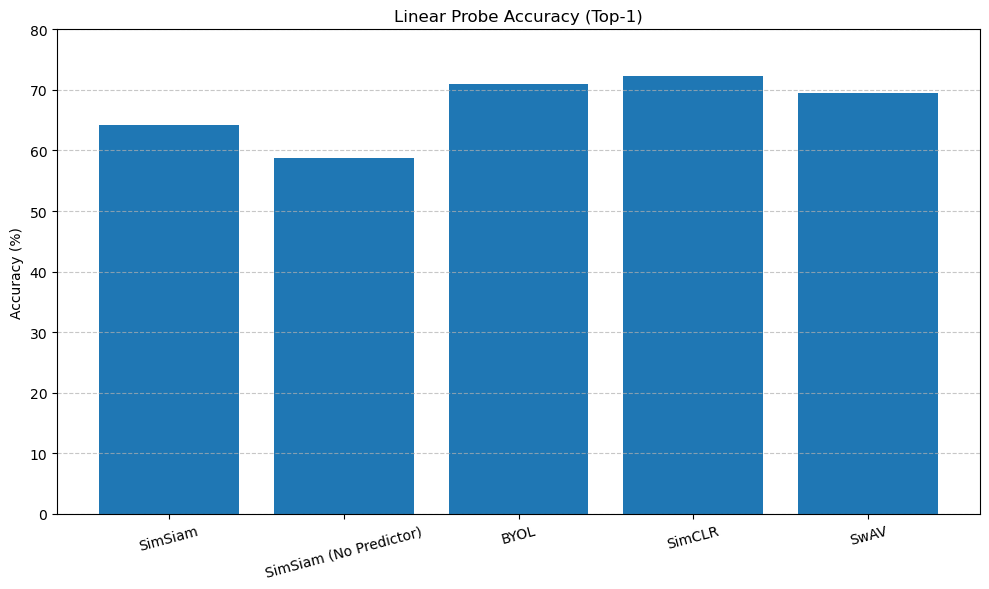

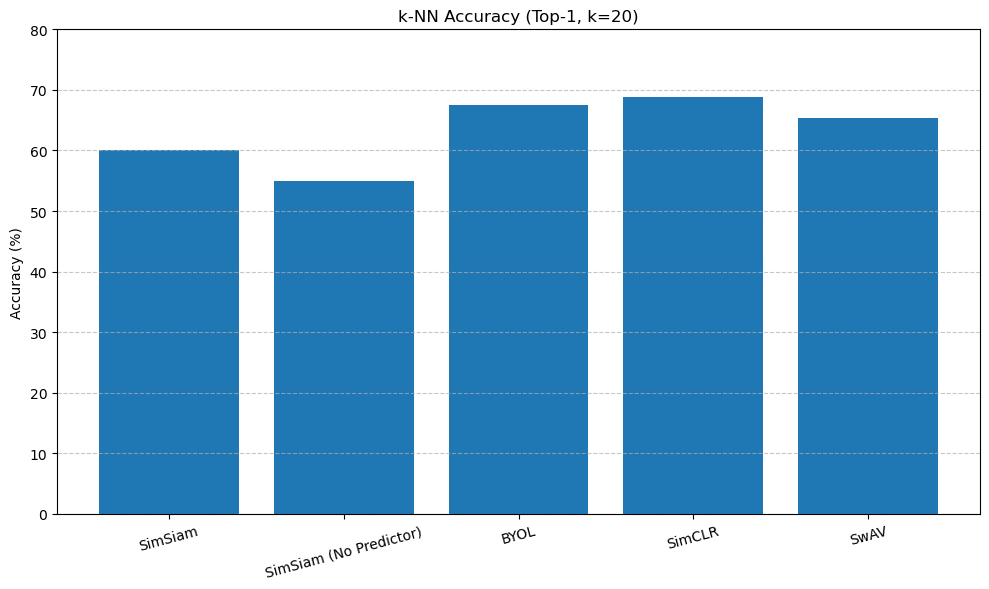

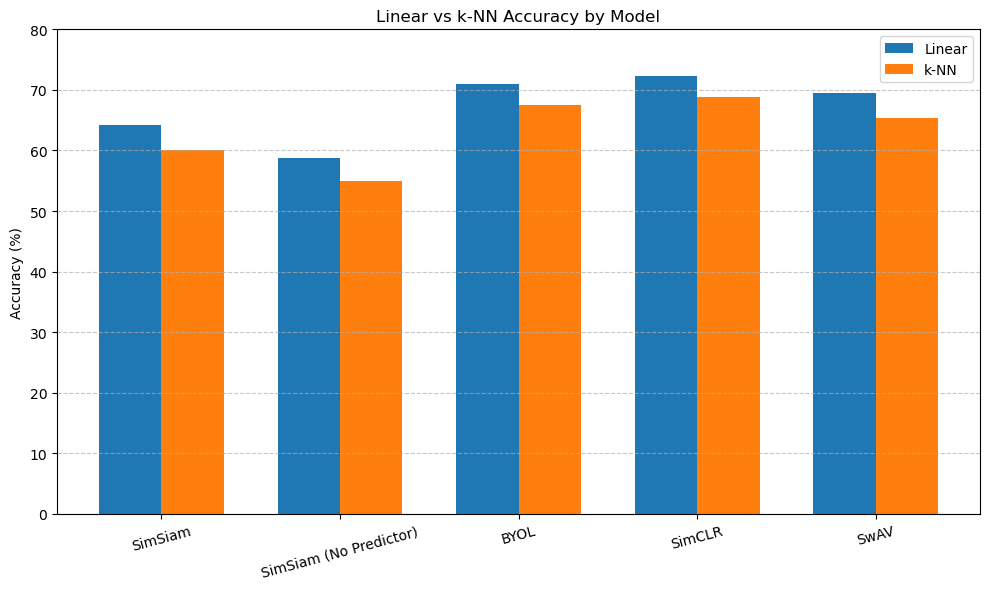

In [162]:
print("\n--- Final Top-1 Accuracy Results ---")
for name, acc in results.items():
    print(f"{name}:")
    print(f"  Linear Probe Accuracy: {acc['linear_top1']:.2f}%")
    print(f"  k-NN Accuracy (k=20):   {acc['knn_top1']:.2f}%\n")
import matplotlib.pyplot as plt

models = list(results.keys())
linear_acc = [v['linear_top1'] for v in results.values()]

plt.figure(figsize=(10, 6))
plt.bar(models, linear_acc)
plt.ylabel("Accuracy (%)")
plt.title("Linear Probe Accuracy (Top-1)")
plt.xticks(rotation=15)
plt.ylim(0, 80)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
knn_acc = [v['knn_top1'] for v in results.values()]

plt.figure(figsize=(10, 6))
plt.bar(models, knn_acc)
plt.ylabel("Accuracy (%)")
plt.title("k-NN Accuracy (Top-1, k=20)")
plt.xticks(rotation=15)
plt.ylim(0, 80)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
import numpy as np

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, linear_acc, width, label='Linear')
bars2 = ax.bar(x + width/2, knn_acc, width, label='k-NN')

ax.set_ylabel('Accuracy (%)')
ax.set_title('Linear vs k-NN Accuracy by Model')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.legend()
ax.set_ylim(0, 80)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
